In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re

In [26]:
# Contoh loading data
data = pd.read_csv('tripadvisor_hotel_reviews.csv')  # Ganti dengan path dataset
print(data.head())

                                              Review  Rating
0  nice hotel expensive parking got good deal sta...       4
1  ok nothing special charge diamond member hilto...       2
2  nice rooms not 4* experience hotel monaco seat...       3
3  unique, great stay, wonderful time hotel monac...       5
4  great stay great stay, went seahawk game aweso...       5


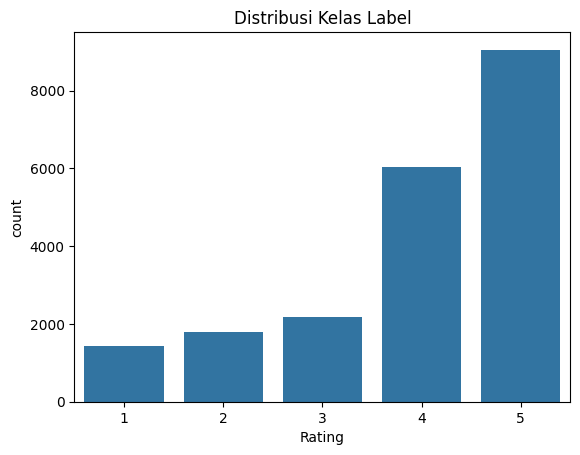

In [27]:
sns.countplot(x='Rating', data=data)
plt.title('Distribusi Kelas Label')
plt.show()

In [28]:
print(data['Review'].sample(5))

15204    perfection possibly best hotel stayed room ipo...
20090    2nd time, going bk year 3rd time, start, first...
4094     enjoyable stay highly recommended thoroughly e...
4771     beautiful modern hotel impressed modern/ conte...
3742     fell love dr riu bambu wife stayed riu bambu g...
Name: Review, dtype: object


In [29]:
# Mengubah rating sesuai dengan kategori yang diinginkan
def categorize_rating(rating):
    if rating in [1, 2]:
        return 0
    elif rating == 3:
        return 1
    elif rating in [4, 5]:
        return 2

# Menerapkan perubahan rating
data['Rating'] = data['Rating'].apply(categorize_rating)

In [30]:
# Pastikan nltk stopwords sudah di-download
nltk.download('stopwords')
nltk.download('punkt')
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    # Lowercase
    text = text.lower()
    # Menghapus angka dan tanda baca
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'\W', ' ', text)
    # Menghapus stopwords
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]
    return ' '.join(tokens)

# Menerapkan fungsi preprocessing ke kolom teks
data['clean_text'] = data['Review'].apply(preprocess_text)
print(data[['Review', 'clean_text']].head())

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\fasha\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\fasha\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


                                              Review  \
0  nice hotel expensive parking got good deal sta...   
1  ok nothing special charge diamond member hilto...   
2  nice rooms not 4* experience hotel monaco seat...   
3  unique, great stay, wonderful time hotel monac...   
4  great stay great stay, went seahawk game aweso...   

                                          clean_text  
0  nice hotel expensive parking got good deal sta...  
1  ok nothing special charge diamond member hilto...  
2  nice rooms experience hotel monaco seattle goo...  
3  unique great stay wonderful time hotel monaco ...  
4  great stay great stay went seahawk game awesom...  


In [31]:
X_train, X_test, y_train, y_test = train_test_split(data['clean_text'], data['Rating'], test_size=0.2, random_state=42)

In [32]:
tfidf_vectorizer = TfidfVectorizer(max_features=5000)  # Menentukan jumlah fitur
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

In [33]:
from xgboost import XGBClassifier

# Inisiasi model XGBoost
xgb_model = XGBClassifier(n_estimators=100, random_state=42, use_label_encoder=False, eval_metric='mlogloss')

# Melatih model
xgb_model.fit(X_train_tfidf, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, objective='multi:softprob', ...)

Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.68      0.73       625
           1       0.48      0.19      0.27       432
           2       0.88      0.98      0.92      3042

    accuracy                           0.85      4099
   macro avg       0.71      0.61      0.64      4099
weighted avg       0.82      0.85      0.82      4099



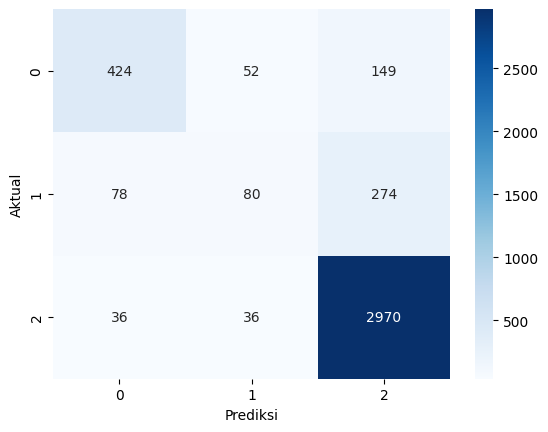

In [34]:
# Prediksi pada data uji
y_pred = xgb_model.predict(X_test_tfidf)

# Evaluasi hasil
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Prediksi')
plt.ylabel('Aktual')
plt.show()

In [35]:
def predict_text(text):
    clean_text = preprocess_text(text)
    text_tfidf = tfidf_vectorizer.transform([clean_text])
    prediction = xgb_model.predict(text_tfidf)
    return prediction[0]

# Contoh prediksi
print(predict_text("i think this hotel is very poor"))

0


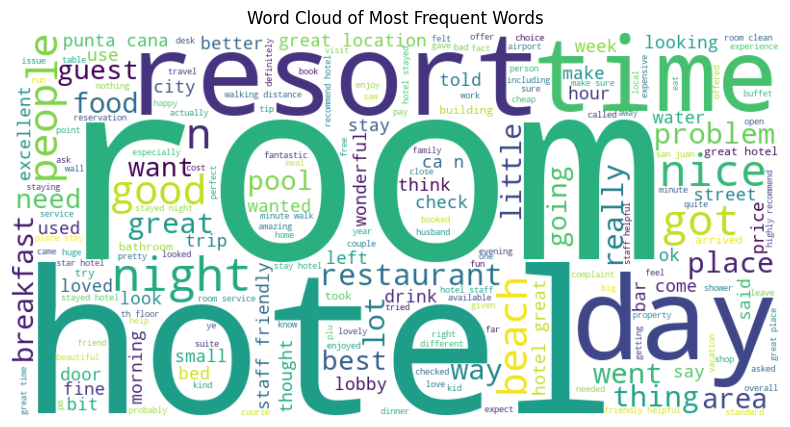

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

all_words = ' '.join(data['clean_text'])

# Membuat Word Cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_words)

# Menampilkan Word Cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud of Most Frequent Words")
plt.show()
